In [1]:
import numpy as np
import matplotlib.pyplot as plt

import utilityfunctions as uf

# Clustering

Clustering algorithms separate a data set into groups, or clusters, that are near each other (similar to each other) using a distance metric we choose or define.

When we fit a regression model, we know the dependent variable - the label, the answer. When we cluster, we don't. Clustering is therefore an *unsupervised* method, although we as data scientists can make all kinds of decisions to influence it.


# K-means clustering

K-means clustering is one clustering algorithm. It divides the data into $k$ clusters. Each cluster has a *centroid*, or central point (or "mean"). 

## What we want to optimize

The points in the dataset are assigned to their closest centroid. In other words, we want to minimize the distances between data points and the centroids they are assigned to, across the whole data set. We want to minimize the *inertia*:
$$inertia = 1/N \sum_{j=1}^N d(\vec{x_j}, \vec{m_{\vec{x_j}}})^2$$, where $\vec{m_{x_j}}$ is the centroid of the cluster that $x_j$ is currently assigned to, and $d$ is your chosen distance metric.

__What does this look like?__

## The algorithm

To make this computationally efficient, we calculate an approximate solution by iteration:
1. Pick initial centroids.
2. For step in range(max_steps):
  1. Assign each point to its closest centroid.
  2. Pick new centroids using the members in each cluster. If the centroids don't change, then return.

__Is this guaranteed to converge?__

## The 'hyperparameters'

Things a data scientist can do to influence the k-means clustering (by __looking at the data__):
* choose distance metric
* choose $k$
* choose starting points, or subset of data from which starting points should come

In [2]:
# Let's define a distance metric; which one is this??
def distance(a, b):
    subtracted = a-b
    return np.sqrt(np.dot(subtracted.T, subtracted))

In [3]:
# Let's define a function to calculate the distance from each data point to each centroid
def get_distances(item, centroids):
    distances = [distance(item, centroid) for centroid in centroids]
    return distances

# Let's define a function to update cluster assignments given a set of centroids
def update_clusters(data, centroids):
    clusters = {}
    mappings = {}
    for i, x in enumerate(centroids):
        clusters[i] = []
    for j, datum in enumerate(data):
        distances = get_distances(datum, centroids)
        min_cluster_index = np.argmin(distances)
        clusters[min_cluster_index].append(datum)
        mappings[j] = min_cluster_index
    return clusters, mappings

In [4]:
# Let's define a function to update the centroids; data is a list of data points; clusters is a dictionary of centroid->datapoints mappings
def update_centroids(clusters):
    centroids = []
    for data_in_cluster in clusters.values():
        centroids.append(np.mean(data_in_cluster, axis=0))
    return centroids

In [5]:
# Let's define a function to measure the inertia
def inertia(data, centroids, clusters):
    sum = 0
    for i in clusters.keys():
        centroid = centroids[i]
        for datum in clusters[i]:
            sum += distance(datum, centroid)**2
    return sum / len(data)

## Let's try it on some toy data!

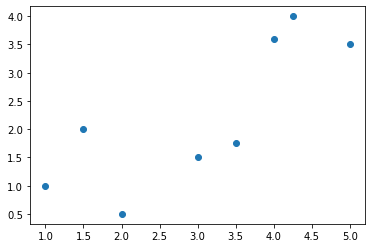

In [6]:
# Let's get some toy data
data = np.array([[1, 1], [2, 0.5], [1.5, 2], [3, 1.5], [3.5, 1.75], [4, 3.6], [4.25, 4], [5, 3.5]])

# Let's look at the data
plt.scatter(data[:, 0], data[:, 1])
plt.show()

In [ ]:
def plot_clusters(data, mappings, centroids):
    plt.scatter(data[:, 0], data[:, 1], c=list(mappings.values()))
    print(centroids)
    for i, centroid in enumerate(centroids):
        plt.scatter(centroid[0], centroid[1], marker=i)
    plt.show()

In [ ]:
# Let's pick k = 2
k = 2

# Let's pick k points to be centroids, at random
centroidids = np.random.choice(np.arange(len(data)), size=k, replace=False)
centroids = [data[x] for x in centroidids]
print("initial centroids")
print(centroids)

# Initially, only the centroids are in any cluster
clusters, mappings = update_clusters(data, centroids)
print(clusters)
plot_clusters(data, mappings, centroids)

In [ ]:
# Let's loop over updating the centroids and plotting
while input() != 'stop':
    centroids = update_centroids(clusters)
    print(centroids)
    clusters, mappings = update_clusters(data, centroids)
    print(clusters)
    print(inertia(data, centroids, clusters))
    plot_clusters(data, mappings, centroids)

## Choosing k

K nearest neighbors can be frustrating, especially with high dimensional data, because you have to choose a value for k. How can you do it, if you can't visualize all the data?

You can inspect an elbow plot of inertia against k, starting with a small k and increasing.

Even if you use this method, it's still important to __look at your data__.

In [ ]:
inertia_by_k = np.array([])

fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(111)
ax1.plot(inertia_by_k[:, 1])
ax1.set_xlabel('k')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Plot')
plt.show()

## Let's try it on the digits data!

In [ ]:
import pandas as pd
import plotly.express as px

data = np.array(np.genfromtxt('data/optdigits/optdigits.tra', delimiter=',', dtype=int)) 
# If we want, we can also make it smaller - to see better. Let's prune to just the numbers 0 through 6
data = data[data[:,64]<6,:]
# And just the first 500 rows
data = data[:500]
print(uf.getShapeType(data))
print(uf.getSummaryStatistics(data))

# Why am I removing the labels?
(data, y) = uf.split(data, data.shape[1]-1)

# For the purposes of visualization, I'm going to use PCA to reduce this dataset to 3 dimensions
data = uf.preprocess(data, zscore=True)
eigenvals, eigenvecs = uf.pca_with_plots(data)

In [ ]:
import plotly.graph_objects as go
from plotly.validators.scatter.marker import SymbolValidator

def project_and_plot_centroids(fig, centroids, eigenvecs, project=True):
    if project:
        v = eigenvecs[:, :3]
        projected_centroids = centroids@v
    else:
        projected_centroids = centroids

    fig.add_trace(go.Scatter3d(x=projected_centroids[:, 0], y=projected_centroids[:, 1], z=projected_centroids[:, 2], mode='markers'))   
    fig.show()
    
def project_and_plot_data(data, labels, clusters, eigenvecs, project=True):
    if project:
        v = eigenvecs[:, :3]
        projected = data@v
    else:
        projected = data

    projected_with_labels = np.hstack((projected, np.array([labels, clusters]).T))
    vals = {0.0: 'circle-open', 1.0: 'cross', 2.0: 'square', 3.0: 'square-open', 4.0: 'diamond', 5.0: 'diamond-open'}
    fig = go.Figure()
    fig.add_trace(go.Scatter3d(x=projected_with_labels[:, 0], y=projected_with_labels[:, 1], z=projected_with_labels[:, 2], mode='markers', marker=dict(size=8, symbol=[vals[(int(x))] for x in projected_with_labels[:, 4]], color=projected_with_labels[:, 3])))
    return fig


### Six clusters, random initialization

Why six?

In [ ]:
k = 6

# Let's pick k points to be centroids, at random
centroidids = np.random.choice(np.arange(len(data)), size=k, replace=False)
centroids = np.array([data[x] for x in centroidids])

clusters = update_clusters(data, centroids)
fig = project_and_plot_data(data, y, clusters, eigenvecs)
project_and_plot_centroids(fig, centroids, eigenvecs)

In [ ]:
# Let's loop over updating the centroids and plotting
while input() != 'stop':
    centroids = update_centroids(data, k, clusters)
    clusters = update_clusters(data, centroids)
    print(inertia(data, centroids, clusters))
    fig = project_and_plot_data(data, y, clusters, eigenvecs)
    project_and_plot_centroids(fig, centroids, eigenvecs)

### Six clusters, non-random initialization

What if I could borrow 10 minutes of your time to label 20 data points, and could use them as the starting centroids?


In [ ]:
centroidids = np.array([0, 11, 5, 14, 3, 6])
centroids = [data[x] for x in centroidids]

clusters = update_clusters(data, centroids)
fig = project_and_plot_data(data, y, clusters, eigenvecs)
project_and_plot_centroids(fig, centroids, eigenvecs)

In [ ]:
# Let's loop over updating the centroids and plotting
while input() != 'stop':
    centroids = update_centroids(data, k, clusters)
    clusters = update_clusters(data, centroids)
    print(inertia(data, centroids, clusters))
    fig = project_and_plot_data(data, y, clusters, eigenvecs)
    project_and_plot_centroids(fig, centroids, eigenvecs)

### In PCA space

... Mostly just for the heck of it :)

BUT if your variables have very different ranges you *must* normalize, or the large-range variables will dominate the clustering.

In [ ]:
v = eigenvecs[:, :3]
projected = data@v

# Let's pick 10 at random
centroidids = np.random.choice(np.arange(len(projected)), size=k, replace=False)
centroids = np.array([projected[x] for x in centroidids])

clusters = update_clusters(projected, centroids)
fig = project_and_plot_data(projected, y, clusters, eigenvecs, project=False)
project_and_plot_centroids(fig, centroids, eigenvecs, project=False)

In [ ]:
# Let's loop over updating the centroids and plotting
while input() != 'stop':
    centroids = update_centroids(projected, k, clusters)
    clusters = update_clusters(projected, centroids)
    
    print(inertia(projected, centroids, clusters))
    fig = project_and_plot_data(projected, y, clusters, eigenvecs, project=False)
    project_and_plot_centroids(fig, centroids, eigenvecs, project=False)

Of course, we want to know how good our clusters are. How can we figure that out? 

As an initial stab, *since we have labels*, let's go through label by label and see how many clusters are assigned to the data with each label.

In [ ]:
projected_with_labels = np.hstack((data, np.array([y, clusters]).T))
print(projected_with_labels.shape)
for label in range(6):
    subset = projected_with_labels[projected_with_labels[:,64]==label,:]
    print(label, subset.shape, np.unique(subset[:, 65], return_counts=True))

What does this tell us?

## Resources
* For a list of lots of clustering algorithms, see https://scikit-learn.org/stable/modules/clustering.html